In [3]:
import os
import itertools
import cv2
import numpy as np
from scipy.io import savemat
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import DBSCAN

mask_path = '/home/suayder/Desktop/00651.npy'
img_path = '/home/suayder/Desktop/00651.jpg'

In [18]:
def show_steps(steps):
    """step is a dict {operation_name: array_result}"""
    if len(steps) == 1:
        for title, image in steps.items():
            plt.imshow(image, cmap='gray')
            plt.title(title)
            plt.axis('off')
        return

    len_images = len(steps)
    rows = int(np.sqrt(len_images))
    cols = int(np.ceil(len_images / rows))
    fig, axes = plt.subplots(rows, cols, figsize=(15,15))
    axes = axes.flatten()
    for idx, (title, image) in enumerate(steps.items()):
            axes[idx].imshow(image, cmap='gray')
            axes[idx].set_title(title)
            axes[idx].axis('off')  # Hide axes ticks

    for idx in range(len_images, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

def line_detection(mask: np.ndarray):
    if mask.ndim != 2:
        raise ValueError("Input array must be 2D (grayscale).")

    edges = cv2.Canny(mask, 50, 200, None, 3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 10, None, 10, 250)

    plot_mask = np.stack([mask]*3, axis=-1)
    if lines is not None:
        for i in range(0, len(lines)):
            l = lines[i][0]
            plot_mask = cv2.line(plot_mask, (l[0], l[1]), (l[2], l[3]), (np.random.randint(0, 255), np.random.randint(0, 255),np.random.randint(0, 255)), 3, cv2.LINE_AA)

    return {'Detected Lines': plot_mask}, lines

def intersection_point(line_1, line_2):
    A,B = line_1[0:2], line_1[2:4]
    C,D = line_2[0:2], line_2[2:4]

    # Line AB represented as a1 * x + b1 * y = c1
    a1 = B[1] - A[1]
    b1 = A[0] - B[0]
    c1 = a1 * A[0] + b1 * A[1]

    # Line CD represented as a2 * x + b2 * y = c2
    a2 = D[1] - C[1]
    b2 = C[0] - D[0]
    c2 = a2 * C[0] + b2 * C[1]

    determinant = a1 * b2 - a2 * b1

    if determinant == 0: # line parallel
        return None

    # Intersection point (x, y)
    x = (b2 * c1 - b1 * c2) / determinant
    y = (a1 * c2 - a2 * c1) / determinant

    # Check if is within the line segments
    if (min(A[0], B[0]) <= x <= max(A[0], B[0]) and
        min(A[1], B[1]) <= y <= max(A[1], B[1]) and
        min(C[0], D[0]) <= x <= max(C[0], D[0]) and
        min(C[1], D[1]) <= y <= max(C[1], D[1])):
        return (x, y)

    return None


def detect_irregularities(mask: np.ndarray):
    """
    Irregularities are detected by finding intersection point in lines
    """
    _, lines = line_detection(mask)
    if lines is None:
        return {'intersection points': cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)}, None

    def increase_line_size(line, k=1.1):
        x0, y0, x1, y1 = list(map(int, line))
        dx = (x1-x0)/2
        dy = (y1-y0)/2
        nx0, ny0 = int(x0 - k/2 * dx), int(y0 - k/2 * dy)
        nx1, ny1 = int(x1 + k/2 * dx), int(y1 + k/2 * dy)
        
        return nx0, ny0, nx1, ny1

    # find intersections
    intersecs = []
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    for line1, line2 in itertools.product(lines, repeat=2):
        intersection = intersection_point(increase_line_size(line1[0]), 
                                          increase_line_size(line2[0]))
        if intersection != None:
            intersecs.append(intersection)
    
    intersecs = np.array(intersecs)

    if len(intersecs)==0:
        return {'intersection points': cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)}, intersecs

    # filter intersections
    dbscan = DBSCAN(eps=15, min_samples=3).fit(intersecs)
    labels = dbscan.labels_

    intersecs = intersecs[labels!=-1]
    labels = labels[labels!=-1]
    colors = {f'{l}': (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)) for l in np.unique(labels)}

    t = []
    for i in intersecs:
        if i[1] > mask.shape[0] or i[0] > mask.shape[1] or i[1] < 0 or i[0] < 0:
            t.append(False)
            continue
        t.append(True)
    intersecs = intersecs[t]
    
    # draw points
    for l, intersections in zip(labels, intersecs):
        x,y = tuple(map(int, intersections))
        mask = cv2.circle(mask, (x,y), 15, colors[str(l)], -1)
    
    return {'intersection points': cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)}, intersecs

def gen_fixations(mask, points, save_path = None):
    y, x = mask.shape
    fixation = np.zeros_like(mask)
    if points is not None:
        for point in points:
            fixation[int(point[1]), int(point[0])] = 255

    if save_path!=None:
        np.save(save_path, fixation)

    return {'fixations': fixation}

def attention_map(mask, points, save_path=None):
    def image_gaussian(shape, point, sigma=30.0):

        x = np.arange(0, shape[1])
        y = np.arange(0, shape[0])
        x, y = np.meshgrid(x, y)
        gaussian = np.exp(-((x - point[0]) ** 2 + (y - point[1]) ** 2) / (2 * sigma ** 2))
    
        return gaussian

    if points is not None and len(points)>0:
        maps = []
        for p in points:
            gauss = (image_gaussian(mask.shape, p)*255).astype('uint8')
            maps.append(gauss)

        salmap = np.stack(maps, axis=-1).astype('uint8')
        if len(maps)>1:
            salmap = salmap.mean(axis=-1)
    else:
        salmap = np.zeros_like(mask)

    if save_path is not None:
        cv2.imwrite(save_path, salmap)

    return {'Salience map': salmap}

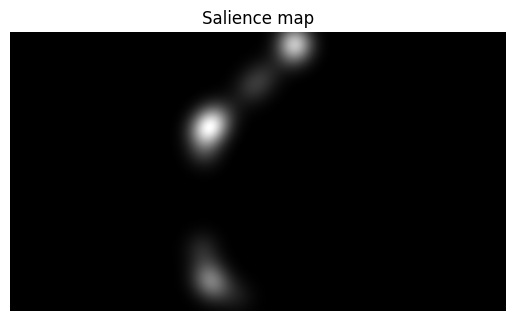

In [30]:
mask = np.moveaxis(np.load(mask_path), 0, 2)
mask = mask.squeeze().astype('uint8') * 255

track = {
    'original image': np.array(Image.open(img_path)),
    'tactile mask': mask
}

res, lines = line_detection(skeleton.astype(np.uint8)*255)
irr, intersections = detect_irregularities(skeleton.astype(np.uint8)*255)
# fix = gen_fixations(mask, intersections, instance.fixations(frame_id))
salmap = attention_map(skeleton.astype(np.uint8)*255, intersections, '00651.jpg')


# show_steps(track)
show_steps(salmap)#| fix | salmap)

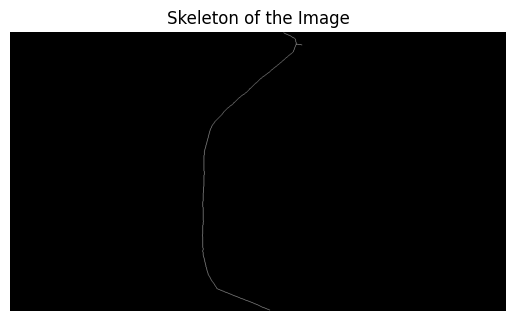

In [21]:
from skimage.morphology import skeletonize

# Generate the skeleton
skeleton = skeletonize(mask)

# Display the skeleton
plt.imshow(skeleton, cmap='gray')
plt.title('Skeleton of the Image')
plt.axis('off')
plt.show()

1